<a href="https://colab.research.google.com/github/Chuc-ngan/Low-Light-Image-Enhancement/blob/main/efficientnetb0_enhanced_low_light_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.18.0  # Thay đổi phiên bản theo nhu cầu
!pip install prettytable

# **1. Connect to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ColabNotebooks/TieuLuan'

!pwd

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1DnsWp1mopgehQJUYpN4ERfnj2CyapJGW/ColabNotebooks/TieuLuan
/content/gdrive/.shortcut-targets-by-id/1DnsWp1mopgehQJUYpN4ERfnj2CyapJGW/ColabNotebooks/TieuLuan


# **2. Import library**

In [ ]:
# ===================== 1. Xử lý dữ liệu =====================
import os
import shutil
import random
import math
import collections
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from prettytable import PrettyTable

# ===================== 2. Machine Learning =====================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ===================== 3. TensorFlow & Keras =====================
import tensorflow as tf
from tensorflow.keras import mixed_precision, regularizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import (
    to_categorical, plot_model, Sequence
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras import layers

# ===================== 4. Xây dựng mô hình =====================
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization,
    GlobalAveragePooling2D, Dense, Dropout, RepeatVector, Reshape,
    Flatten, concatenate
)
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from keras.applications.inception_resnet_v2 import (
    InceptionResNetV2, preprocess_input, decode_predictions
)
from keras import backend as K

# ===================== 5. Xử lý hình ảnh & Vẽ biểu đồ =====================
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== 6. Đánh giá chất lượng ảnh =====================
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ===================== 7. Đặt Seed (Reproducibility) =====================
tf.random.set_seed(42)
np.random.seed(1)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# **3. TensorFlow environment configuration**

In [ ]:
# Thiết lập GPU sử dụng bộ nhớ động (tránh lỗi thiếu bộ nhớ)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Kiểm tra TensorFlow đang chạy trên GPU hay không
print("TensorFlow is running on GPU:", tf.test.is_built_with_cuda())
# Bật chế độ Mixed Precision để tăng tốc (nếu GPU hỗ trợ)
# Thiết lập mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Bật XLA với cấu hình tối ưu
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({
    "layout_optimizer": True,
    "constant_folding": True,
    "shape_optimization": True,
    "remapping": True,
    "arithmetic_optimization": True,
    "dependency_optimization": True,
    "loop_optimization": True,
    "function_optimization": True,
    "debug_stripper": True
})

TensorFlow is running on GPU: True


# **4. Configuration**

In [ ]:
# Đường dẫn thư mục gốc
data_dir = "dataset/images"

# Thư mục đích
train_dir = "dataset/train"
val_dir = "dataset/validation"
test_dir = "dataset/test"

# Thư mục thiếu sáng
low_light_dir = "dataset/low_light"
low_light_noise_dir = "dataset/low_light_noise"

# Ảnh đã tăng cường bằng Histogram Equalization (HE)
enhanced_he_low_light_dir = "dataset/enhanced_he_low_light"
enhanced_he_low_light_noise_dir = "dataset/enhanced_he_low_light_noise"

# Ảnh đã tăng cường bằng Retinex
enhanced_retinex_low_light_dir = "dataset/enhanced_retinex_low_light"
enhanced_retinex_low_light_noise_dir = "dataset/enhanced_retinex_low_light_noise"

# Ảnh đã tăng cường bằng phương pháp Wavelet
enhanced_wavelet_low_light_dir = "dataset/enhanced_wavelet_low_light"
enhanced_wavelet_low_light_noise_dir = "dataset/enhanced_wavelet_low_light_noise"

# Ảnh đã tăng cường bằng mô hình CNN
enhanced_cnn_low_light_dir = "dataset/enhanced_cnn_low_light"
enhanced_cnn_low_light_noise_dir = "dataset/enhanced_cnn_low_light_noise"

SPLIT_RATIO = 0.5  # Chỉ lấy 50%
# Configuration
IMG_SIZE = 224  # Slightly larger for more detail
CHANEL = 3
BATCH_SIZE = 32
EPOCHS = 3
VAL_SPLIT = 0.2
RANDOM_SEED = 42

# **5. Setup and data loading**

## **5.1 Load dataset**

### 5.1.1 Load train dataset

In [ ]:
# Load train dataset
train_df = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed =123,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)
# Đảm bảo số lớp trong test giống train
class_names = train_df.class_names  # Lấy class từ train
NUM_CLASSES = len(class_names)

# In thông tin dataset
print(f"Số lớp: {NUM_CLASSES}, Danh sách lớp: {class_names}")
print(f"Số batch train: {len(train_df)}")

Found 20808 files belonging to 4 classes.
Using 16647 files for training.
Số lớp: 4, Danh sách lớp: ['architecture', 'art and culture', 'food and drinks', 'travel and adventure']
Số batch train: 521


### 5.1.2 Load validation dataset

In [ ]:
# Load validation dataset
val_df = image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="training",
    seed =123,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)
print(f"Số batch val: {len(val_df)}")

Found 3467 files belonging to 4 classes.
Using 2774 files for training.
Số batch val: 87


### 5.1.3 Load test dataset

In [ ]:
# Load test dataset
test_df = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch test: {len(test_df)}")

Found 10402 files belonging to 4 classes.
Số batch test: 326


### 5.1.4 Load low light dataset

In [ ]:
low_light_df = image_dataset_from_directory(
    low_light_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch low light: {len(low_light_df)}")

### 5.1.5 Load low light + noise dataset

In [ ]:
low_light_noise_df = image_dataset_from_directory(
    low_light_noise_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch low light with noise: {len(low_light_noise_df)}")

### 5.1.6 Load enhanced image datasets for Histogram Equalization (HE) in low light conditions

In [ ]:
# Load enhanced image datasets for Histogram Equalization (HE) in low light conditions
enhanced_he_low_light_df = image_dataset_from_directory(
    enhanced_he_low_light_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced HE low light: {len(enhanced_he_low_light_df)}")

Found 10402 files belonging to 4 classes.
Số batch enhanced HE low light: 326


### 5.1.7 Load enhanced image datasets for Histogram Equalization (HE) in low light conditions with noise

In [ ]:
#Load enhanced image datasets for Histogram Equalization (HE) in low light conditions with noise
enhanced_he_low_light_noise_df = image_dataset_from_directory(
    enhanced_he_low_light_noise_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced HE low light with noise: {len(enhanced_he_low_light_noise_df)}")

Found 10402 files belonging to 4 classes.
Số batch enhanced HE low light with noise: 326


### 5.1.8 Load enhanced image datasets for Retinex (REXNet) in low light conditions

In [ ]:
# Load enhanced image datasets for Retinex (REXNet) in low light conditions
enhanced_retinex_low_light_df = image_dataset_from_directory(
    enhanced_retinex_low_light_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced Retinex low light: {len(enhanced_retinex_low_light_df)}")

Found 10402 files belonging to 4 classes.
Số batch enhanced Retinex low light: 326


### 5.1.9 Load enhanced image datasets for Retinex (REXNet) in low light conditions with noise

In [ ]:
# Load enhanced image datasets for Retinex (REXNet) in low light conditions with noise
enhanced_retinex_low_light_noise_df = image_dataset_from_directory(
    enhanced_retinex_low_light_noise_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced Retinex low light with noise: {len(enhanced_retinex_low_light_noise_df)}")

Found 10402 files belonging to 4 classes.
Số batch enhanced Retinex low light with noise: 326


### 5.1.10 Load enhanced image datasets for Wavelet enhancement in low light conditions

In [ ]:
# Load enhanced image datasets for Wavelet enhancement in low light conditions
enhanced_wavelet_low_light_df = image_dataset_from_directory(
    enhanced_wavelet_low_light_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced wavelet low light: {len(enhanced_wavelet_low_light_df)}")

Found 10402 files belonging to 4 classes.
Số batch enhanced wavelet low light: 326


### 5.1.11 Load enhanced image datasets for Wavelet enhancement in low light conditions with noise

In [ ]:
# Load enhanced image datasets for Wavelet enhancement in low light conditions with noise
enhanced_wavelet_low_light_noise_df = image_dataset_from_directory(
    enhanced_wavelet_low_light_noise_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced wavelet low light with noise: {len(enhanced_wavelet_low_light_noise_df)}")

Found 10402 files belonging to 4 classes.
Số batch enhanced wavelet low light with noise: 326


### **5.1.12 Load enhanced image datasets for CNN-based enhancement in low light conditions**

In [ ]:
# Load enhanced image datasets for CNN-based enhancement in low light conditions
enhanced_cnn_low_light_df = image_dataset_from_directory(
    enhanced_cnn_low_light_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced CNN low light: {len(enhanced_cnn_low_light_df)}")

Found 10370 files belonging to 4 classes.
Số batch enhanced CNN low light: 325


### 5.1.13 Load enhanced image datasets for CNN-based enhancement in low light conditions with noise

In [ ]:
# Load enhanced image datasets for CNN-based enhancement in low light conditions with noise
enhanced_cnn_low_light_noise_df = image_dataset_from_directory(
    enhanced_cnn_low_light_noise_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Số batch enhanced CNN low light with noise: {len(enhanced_cnn_low_light_noise_df)}")

Found 10370 files belonging to 4 classes.
Số batch enhanced CNN low light with noise: 325


## **5.2 Data augmentation**

In [ ]:
# Hàm tăng cường ảnh (augmentation)
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
    # layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    # layers.GaussianNoise(stddev=0.05),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

## **5.3 Visualizing the data**

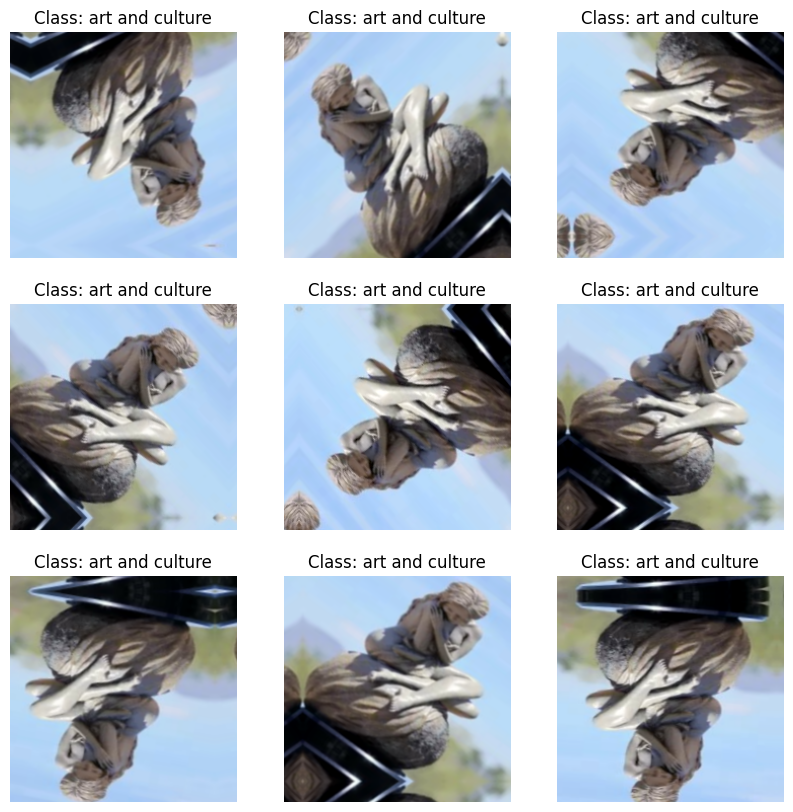

In [ ]:
# Lấy batch đầu tiên từ dataset
for image_batch, label_batch in train_df.take(1):
    first_image = image_batch[0]  # Lấy ảnh đầu tiên trong batch
    first_label = label_batch[0]  # Lấy nhãn đầu tiên
    break  # Chỉ lấy 1 batch duy nhất

# Hiển thị ảnh gốc + 8 biến thể augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Áp dụng augmentation
    aug_img = img_augmentation(tf.expand_dims(first_image, axis=0))  # Thêm batch dimension
    aug_img = tf.squeeze(aug_img, axis=0)  # Loại bỏ batch dimension

    # Hiển thị ảnh đã biến đổi
    plt.imshow(aug_img.numpy().astype("uint8"))
    plt.title(f"Class: {class_names[first_label.numpy()]}")
    plt.axis("off")

plt.show()

## **5.4 Prepare inputs**

### 5.4.1 Data Preprocessing Function for Train Data with Augmentation and One-Hot Encoding

In [ ]:
# Data preprocessing function for train data with augmentation and one-hot encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)  # Áp dụng augment
    label = tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES)  # One-hot encoding label
    return image, label

### 5.4.2 Data Preprocessing Function for Test Data with One-Hot Encoding

In [ ]:
# Data preprocessing function for test data with one-hot encoding
def input_preprocess_test(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES)  # One-hot encode label
    return image, label

### 5.4.3 Load and Preprocess Training Data with Augmentation and One-Hot Encoding

In [ ]:
# Tải và xử lý dữ liệu với augmentation và one-hot encoding
train_df = train_df.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)  # Áp dụng augment và one-hot
val_df = val_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Cache và prefetch để tối ưu hiệu suất
train_df = train_df.cache().prefetch(tf.data.AUTOTUNE)
val_df = val_df.cache().prefetch(tf.data.AUTOTUNE)

### 5.4.4 Load and Preprocess Test Data with One-Hot Encoding

In [ ]:
# Tải và xử lý dữ liệu test với one-hot encoding
test_df = test_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)  # One-hot encoding
low_light_df = low_light_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
low_light_noise_df = low_light_noise_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Cache và prefetch để tối ưu hiệu suất
test_df = test_df.cache().prefetch(tf.data.AUTOTUNE)
low_light_df = low_light_df.cache().prefetch(tf.data.AUTOTUNE)
low_light_noise_df = low_light_noise_df.cache().prefetch(tf.data.AUTOTUNE)

### 5.4.5 Load and Preprocess Histogram Equalization (HE) Enhanced Data with One-Hot Encoding

In [ ]:
# Load and preprocess Histogram Equalization (HE) enhanced data with one-hot encoding
enhanced_he_low_light_df = enhanced_he_low_light_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
enhanced_he_low_light_noise_df = enhanced_he_low_light_noise_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Cache và prefetch để tối ưu hiệu suất
enhanced_he_low_light_df = enhanced_he_low_light_df.cache().prefetch(tf.data.AUTOTUNE)
enhanced_he_low_light_noise_df = enhanced_he_low_light_noise_df.cache().prefetch(tf.data.AUTOTUNE)

### 5.4.6 Load and Preprocess Retinex Enhanced Data with One-Hot Encoding

In [ ]:
# Load and preprocess Retinex enhanced data with one-hot encoding
enhanced_retinex_low_light_df = enhanced_retinex_low_light_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
enhanced_retinex_low_light_noise_df = enhanced_retinex_low_light_noise_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Cache và prefetch để tối ưu hiệu suất
enhanced_retinex_low_light_df = enhanced_retinex_low_light_df.cache().prefetch(tf.data.AUTOTUNE)
enhanced_retinex_low_light_noise_df = enhanced_retinex_low_light_noise_df.cache().prefetch(tf.data.AUTOTUNE)

### 5.4.7 Load and Preprocess Wavelet Enhanced Data with One-Hot Encoding

In [ ]:
# Load and preprocess Wavelet enhanced data with one-hot encoding
enhanced_wavelet_low_light_df = enhanced_wavelet_low_light_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
enhanced_wavelet_low_light_noise_df = enhanced_wavelet_low_light_noise_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Cache và prefetch để tối ưu hiệu suất
enhanced_wavelet_low_light_df = enhanced_wavelet_low_light_df.cache().prefetch(tf.data.AUTOTUNE)
enhanced_wavelet_low_light_noise_df = enhanced_wavelet_low_light_noise_df.cache().prefetch(tf.data.AUTOTUNE)

### 5.4.8 Load and Preprocess CNN-Based Enhanced Data with One-Hot Encoding

In [ ]:
# Load and preprocess CNN-based enhanced data with one-hot encoding
enhanced_cnn_low_light_df = enhanced_cnn_low_light_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
enhanced_cnn_low_light_noise_df = enhanced_cnn_low_light_noise_df.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Cache và prefetch để tối ưu hiệu suất
enhanced_cnn_low_light_df = enhanced_cnn_low_light_df.cache().prefetch(tf.data.AUTOTUNE)
enhanced_cnn_low_light_noise_df = enhanced_cnn_low_light_noise_df.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
for image, label in val_df.take(1):  # Chỉ lấy 1 batch nhỏ
    print("Image shape:", image.numpy().shape)
    print("Label shape:", label.numpy().shape)


Image shape: (32, 224, 224, 3)
Label shape: (32, 4)


In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

# **6. Transfer learning from pre-trained weights**

## **6.1 Build model EfficientNetB0**

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01))(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = Model(inputs, outputs, name="EfficientNet")
    optimizer = Adam(learning_rate=1e-4)  # Hoặc thậm chí 1e-5
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    # optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
    # model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_model(num_classes=NUM_CLASSES)
# Kiểm tra mô hình
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,712,615 (17.98 MB)

 Trainable params: 660,484 (2.52 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

## **6.2 Pre-trained**

In [ ]:
checkpoint = ModelCheckpoint(
    'model/model.weights.h5',  # Đúng định dạng
    monitor='val_loss',  # Theo dõi validation loss
    save_best_only=True,  # Chỉ lưu khi tốt hơn mô hình trước
    save_weights_only=True,  # Chỉ lưu trọng số
    mode='min',  # Giảm loss thì tốt hơn
    verbose=1
)

epochs = 5  # @param {"type":"slider","min":5,"max":80,"step":1}

# Huấn luyện và lưu mô hình
hist = model.fit(train_df, epochs=epochs, validation_data=val_df, callbacks=[checkpoint])

Epoch 1/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7620 - loss: 7.2323 
Epoch 1: val_loss improved from inf to 4.62840, saving model to model/model.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 7647s 15s/step - accuracy: 0.7622 - loss: 7.2304 - val_accuracy: 0.9290 - val_loss: 4.6284
Epoch 2/5
519/521 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9113 - loss: 4.0990
Epoch 2: val_loss improved from 4.62840 to 2.65464, saving model to model/model.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.9113 - loss: 4.0960 - val_accuracy: 0.9337 - val_loss: 2.6546
Epoch 3/5
520/521 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9331 - loss: 2.3279
Epoch 3: val_loss improved from 2.65464 to 1.55925, saving model to model/model.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9331 - loss: 2.3268 - val_accuracy: 0.9348 - val_loss: 1.5593
Epoch 4/5
519/521 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9405 - loss: 1.3651
Epoch 4: val_loss improved fr

10h 3p 18s
accuracy: 0.9565 - loss: 0.1346 - val_accuracy: 0.9374 - val_loss: 0.2008

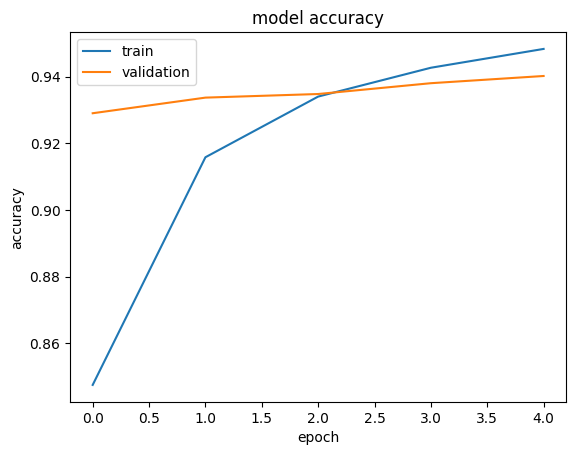

In [ ]:
# Vẽ biểu đồ accuracy
plot_hist(hist)

## **6.3 Load Pre-train**


In [ ]:
model = build_model(num_classes=NUM_CLASSES)  # Xây dựng lại kiến trúc mô hình
model.load_weights("model/model.weights.h5")  # Tải trọng số đã lưu

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## **6.4 Fine-turned**

In [ ]:
def unfreeze_model(model, trainable_layers=20, learning_rate=1e-5):
    """Mở khóa N tầng cuối của mô hình và giữ nguyên BatchNorm"""
    print(f"Total layers in model: {len(model.layers)}")  # Debug

    for layer in model.layers[-trainable_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# Mở khóa các layer để fine-tune
unfreeze_model(model, trainable_layers=20, learning_rate=1e-5)

checkpoint_finetune = ModelCheckpoint(
    'model/model_fine_tuned.weights.h5',  # Lưu trọng số
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,  # Chỉ lưu trọng số
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Dừng sau 5 epoch nếu val_loss không giảm
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

epochs = 25

# Tiếp tục huấn luyện với mô hình fine-tune
hist = model.fit(
    train_df,
    epochs=epochs,
    validation_data=val_df,
    callbacks=[checkpoint_finetune, early_stop, reduce_lr]
    )


Total layers in model: 243
Epoch 1/25
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9275 - loss: 0.2098
Epoch 1: val_loss improved from inf to 0.18580, saving model to model/model_fine_tuned.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 4428s 8s/step - accuracy: 0.9275 - loss: 0.2098 - val_accuracy: 0.9475 - val_loss: 0.1858 - learning_rate: 1.0000e-05
Epoch 2/25
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9309 - loss: 0.1929
Epoch 2: val_loss improved from 0.18580 to 0.18208, saving model to model/model_fine_tuned.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9309 - loss: 0.1929 - val_accuracy: 0.9492 - val_loss: 0.1821 - learning_rate: 1.0000e-05
Epoch 3/25
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9407 - loss: 0.1713
Epoch 3: val_loss improved from 0.18208 to 0.17537, saving model to model/model_fine_tuned.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9407 - loss: 0.1712 - val_accuracy: 0.9504 - val_loss: 0.1754

In [ ]:
# Vẽ biểu đồ accuracy
plot_hist(hist)

## **6.4 Load fine-turned**

In [ ]:
model = build_model(num_classes=NUM_CLASSES)
unfreeze_model(model, trainable_layers=20, learning_rate=1e-5)
model.load_weights("model/model_fine_tuned.weights.h5")  # Load trọng số fine-tuned

Total layers in model: 243


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# **7. Predict and Save**

In [ ]:
def predict_and_save(model, dataset, save_path="predictions.npy"):
    predictions = []
    labels = []

    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images, verbose=0)
        predictions.extend(preds)
        labels.extend(batch_labels.numpy())  # one-hot nếu có

    predictions = np.array(predictions)
    labels = np.array(labels)

    # Lưu predictions và labels để dùng sau (phân tích, báo cáo, v.v.)
    np.savez(save_path, predictions=predictions, labels=labels)
    print(f"✅ Đã lưu: {save_path}")
    return predictions, labels

## **7.1 Predict on the normal test dataset**

In [ ]:
normal_preds, normal_labels = predict_and_save(model, test_df, "report/normal_preds.npz")

## **7.2 Predict and Save - Low Light Dataset**

In [ ]:
low_light_preds, low_light_labels = predict_and_save(model, low_light_df, "report/low_light_preds.npz")

## **7.3 Predict and Save - Low Light Noise Dataset**

In [ ]:
low_light_noise_preds, low_light_noise_labels = predict_and_save(model, low_light_noise_df, "report/low_light_noise_preds.npz")

✅ Đã lưu: report/low_light_noise_preds.npz


## **7.4 Predict and Save - Enhanced HE Low Light Dataset**

In [ ]:
# Predict and save for the enhanced HE low light dataset
enhanced_he_low_light_preds, enhanced_he_low_light_labels = predict_and_save(
    model, enhanced_he_low_light_df, "report/enhanced_he_low_light_preds.npz"
)

✅ Đã lưu: report/enhanced_he_low_light_preds.npz


## **7.5 Predict and Save - Enhanced HE Low Light Noise Dataset**

In [ ]:
# Predict and save for the enhanced HE low light noise dataset
enhanced_he_low_light_noise_preds, enhanced_he_low_light_noise_labels = predict_and_save(
    model, enhanced_he_low_light_noise_df, "report/enhanced_he_low_light_noise_preds.npz"
)

✅ Đã lưu: report/enhanced_he_low_light_noise_preds.npz


## **7.6 Predict and Save - Enhanced Retinex Low Light Dataset**

In [ ]:
# Predict and save for the enhanced Retinex low light dataset
enhanced_retinex_low_light_preds, enhanced_retinex_low_light_labels = predict_and_save(
    model, enhanced_retinex_low_light_df, "report/enhanced_retinex_low_light_preds.npz"
)

✅ Đã lưu: report/enhanced_retinex_low_light_preds.npz


## **7.7 Predict and Save - Enhanced Retinex Low Light Noise Dataset**

In [ ]:
# Predict and save for the enhanced Retinex low light noise dataset
enhanced_retinex_low_light_noise_preds, enhanced_retinex_low_light_noise_labels = predict_and_save(
    model, enhanced_retinex_low_light_noise_df, "report/enhanced_retinex_low_light_noise_preds.npz"
)

✅ Đã lưu: report/enhanced_retinex_low_light_noise_preds.npz


## **7.8 Predict and Save - Enhanced Wavelet Low Light Dataset**

In [ ]:
# Predict and save for the enhanced Wavelet low light dataset
enhanced_wavelet_low_light_preds, enhanced_wavelet_low_light_labels = predict_and_save(
    model, enhanced_wavelet_low_light_df, "report/enhanced_wavelet_low_light_preds.npz"
)

✅ Đã lưu: report/enhanced_wavelet_low_light_preds.npz


## **7.9 Predict and Save - Enhanced Wavelet Low Light Noise Dataset**

In [ ]:
# Predict and save for the enhanced Wavelet low light noise dataset
enhanced_wavelet_low_light_noise_preds, enhanced_wavelet_low_light_noise_labels = predict_and_save(
    model, enhanced_wavelet_low_light_noise_df, "report/enhanced_wavelet_low_light_noise_preds.npz"
)

✅ Đã lưu: report/enhanced_wavelet_low_light_noise_preds.npz


## **7.10 Predict and Save - Enhanced CNN Low Light Dataset**

In [ ]:
# Predict and save for the enhanced CNN low light dataset
enhanced_cnn_low_light_preds, enhanced_cnn_low_light_labels = predict_and_save(
    model, enhanced_cnn_low_light_df, "report/enhanced_cnn_low_light_preds.npz"
)

✅ Đã lưu: report/enhanced_cnn_low_light_preds.npz


## **7.11 Predict and Save - Enhanced CNN Low Light Noise Dataset**

In [ ]:
# Predict and save for the enhanced CNN low light noise dataset
enhanced_cnn_low_light_noise_preds, enhanced_cnn_low_light_noise_labels = predict_and_save(
    model, enhanced_cnn_low_light_noise_df, "report/enhanced_cnn_low_light_noise_preds.npz"
)

✅ Đã lưu: report/enhanced_cnn_low_light_noise_preds.npz


# **8. Load and Report**

In [ ]:
def load_and_report(npz_path, class_names):
    data = np.load(npz_path)
    y_true = np.argmax(data["labels"], axis=1)
    y_pred = np.argmax(data["predictions"], axis=1)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return report

## **8.1 Report for Normal Dataset**

In [ ]:
normal_report = load_and_report("report/normal_preds.npz", class_names)
print("📊 Report for Normal Dataset:")
print(classification_report(
    np.argmax(np.load("report/normal_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/normal_preds.npz")["predictions"], axis=1),
    target_names=class_names
))

📊 Report for Normal Dataset:
                      precision    recall  f1-score   support

        architecture       0.99      0.98      0.98      2598
     art and culture       0.90      0.95      0.92      2560
     food and drinks       0.97      0.96      0.96      2604
travel and adventure       0.93      0.90      0.92      2640

            accuracy                           0.95     10402
           macro avg       0.95      0.95      0.95     10402
        weighted avg       0.95      0.95      0.95     10402



## **8.2 Report for Low Light Dataset**

In [ ]:
low_light_report = load_and_report("report/low_light_preds.npz", class_names)
print("📊 Report for Low Light Dataset:")
print(classification_report(
    np.argmax(np.load("report/low_light_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/low_light_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Low Light Dataset:
                      precision    recall  f1-score   support

        architecture       0.99      0.91      0.94      2598
     art and culture       0.86      0.90      0.88      2560
     food and drinks       0.97      0.91      0.94      2604
travel and adventure       0.82      0.90      0.86      2640

            accuracy                           0.90     10402
           macro avg       0.91      0.90      0.91     10402
        weighted avg       0.91      0.90      0.91     10402



## **8.3 Report for Low Light + Noise Dataset**

In [ ]:
low_light_noise_report = load_and_report("report/low_light_noise_preds.npz", class_names)
print("📊 Report for Low Light + Noise Dataset:")
print(classification_report(
    np.argmax(np.load("report/low_light_noise_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/low_light_noise_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Low Light + Noise Dataset:
                      precision    recall  f1-score   support

        architecture       0.99      0.49      0.66      2598
     art and culture       0.63      0.94      0.75      2560
     food and drinks       0.96      0.83      0.89      2604
travel and adventure       0.67      0.78      0.72      2640

            accuracy                           0.76     10402
           macro avg       0.81      0.76      0.76     10402
        weighted avg       0.81      0.76      0.76     10402



## **8.4 Report for Enhanced HE Low Light Dataset**

In [ ]:
enhanced_he_low_light_report = load_and_report("report/enhanced_he_low_light_preds.npz", class_names)
print("📊 Report for Enhanced HE Low Light Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_he_low_light_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_he_low_light_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced HE Low Light Dataset:
                      precision    recall  f1-score   support

        architecture       0.98      0.89      0.93      2598
     art and culture       0.85      0.91      0.88      2560
     food and drinks       0.97      0.92      0.94      2604
travel and adventure       0.82      0.89      0.86      2640

            accuracy                           0.90     10402
           macro avg       0.91      0.90      0.90     10402
        weighted avg       0.91      0.90      0.90     10402



## **8.5 Report for Enhanced HE Low Light + Noise Dataset**

In [ ]:
enhanced_he_low_light_noise_report = load_and_report("report/enhanced_he_low_light_noise_preds.npz", class_names)
print("📊 Report for Enhanced HE Low Light + Noise Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_he_low_light_noise_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_he_low_light_noise_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced HE Low Light + Noise Dataset:
                      precision    recall  f1-score   support

        architecture       0.98      0.53      0.69      2598
     art and culture       0.65      0.93      0.76      2560
     food and drinks       0.96      0.84      0.90      2604
travel and adventure       0.67      0.78      0.73      2640

            accuracy                           0.77     10402
           macro avg       0.82      0.77      0.77     10402
        weighted avg       0.82      0.77      0.77     10402



## **8.6 Report for Enhanced Retinex Low Light Dataset**

In [ ]:
enhanced_retinex_low_light_report = load_and_report("report/enhanced_retinex_low_light_preds.npz", class_names)
print("📊 Report for Enhanced Retinex Low Light Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_retinex_low_light_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_retinex_low_light_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced Retinex Low Light Dataset:
                      precision    recall  f1-score   support

        architecture       0.99      0.83      0.90      2598
     art and culture       0.82      0.93      0.87      2560
     food and drinks       0.97      0.93      0.95      2604
travel and adventure       0.82      0.86      0.84      2640

            accuracy                           0.89     10402
           macro avg       0.90      0.89      0.89     10402
        weighted avg       0.90      0.89      0.89     10402



## **8.7 Report for Enhanced Retinex Low Light + Noise Dataset**

In [ ]:
enhanced_retinex_low_light_noise_report = load_and_report("report/enhanced_retinex_low_light_noise_preds.npz", class_names)
print("📊 Report for Enhanced Retinex Low Light + Noise Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_retinex_low_light_noise_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_retinex_low_light_noise_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced Retinex Low Light + Noise Dataset:
                      precision    recall  f1-score   support

        architecture       0.98      0.55      0.70      2598
     art and culture       0.66      0.93      0.77      2560
     food and drinks       0.96      0.85      0.90      2604
travel and adventure       0.70      0.80      0.74      2640

            accuracy                           0.78     10402
           macro avg       0.83      0.78      0.78     10402
        weighted avg       0.83      0.78      0.78     10402



## **8.8 Report for Enhanced Wavelet Low Light Dataset**

In [ ]:
enhanced_wavelet_low_light_report = load_and_report("report/enhanced_wavelet_low_light_preds.npz", class_names)
print("📊 Report for Enhanced Wavelet Low Light Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_wavelet_low_light_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_wavelet_low_light_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced Wavelet Low Light Dataset:
                      precision    recall  f1-score   support

        architecture       0.99      0.90      0.94      2598
     art and culture       0.86      0.90      0.88      2560
     food and drinks       0.97      0.91      0.94      2604
travel and adventure       0.82      0.90      0.86      2640

            accuracy                           0.90     10402
           macro avg       0.91      0.90      0.90     10402
        weighted avg       0.91      0.90      0.90     10402



## **8.9 Report for Enhanced Wavelet Low Light + Noise Dataset**

In [ ]:
enhanced_wavelet_low_light_noise_report = load_and_report("report/enhanced_wavelet_low_light_noise_preds.npz", class_names)
print("📊 Report for Enhanced Wavelet Low Light + Noise Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_wavelet_low_light_noise_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_wavelet_low_light_noise_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced Wavelet Low Light + Noise Dataset:
                      precision    recall  f1-score   support

        architecture       0.99      0.49      0.65      2598
     art and culture       0.59      0.94      0.73      2560
     food and drinks       0.96      0.80      0.87      2604
travel and adventure       0.68      0.74      0.71      2640

            accuracy                           0.74     10402
           macro avg       0.81      0.74      0.74     10402
        weighted avg       0.81      0.74      0.74     10402



## **8.10 Report for Enhanced CNN Low Light Dataset**

In [ ]:
enhanced_cnn_low_light_report = load_and_report("report/enhanced_cnn_low_light_preds.npz", class_names)
print("📊 Report for Enhanced CNN Low Light Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_cnn_low_light_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_cnn_low_light_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced CNN Low Light Dataset:
                      precision    recall  f1-score   support

        architecture       0.98      0.94      0.96      2598
     art and culture       0.88      0.91      0.89      2560
     food and drinks       0.96      0.95      0.96      2572
travel and adventure       0.87      0.89      0.88      2640

            accuracy                           0.92     10370
           macro avg       0.92      0.92      0.92     10370
        weighted avg       0.92      0.92      0.92     10370



## **8.11 Report for Enhanced CNN Low Light + Noise Dataset**

In [ ]:
enhanced_cnn_low_light_noise_report = load_and_report("report/enhanced_cnn_low_light_noise_preds.npz", class_names)
print("📊 Report for Enhanced CNN Low Light + Noise Dataset:")
print(classification_report(
    np.argmax(np.load("report/enhanced_cnn_low_light_noise_preds.npz")["labels"], axis=1),
    np.argmax(np.load("report/enhanced_cnn_low_light_noise_preds.npz")["predictions"], axis=1),
    target_names=class_names
))


📊 Report for Enhanced CNN Low Light + Noise Dataset:
                      precision    recall  f1-score   support

        architecture       0.99      0.76      0.86      2598
     art and culture       0.78      0.93      0.85      2560
     food and drinks       0.97      0.92      0.94      2572
travel and adventure       0.76      0.83      0.80      2640

            accuracy                           0.86     10370
           macro avg       0.88      0.86      0.86     10370
        weighted avg       0.87      0.86      0.86     10370



# **9. Confusion Matrix**

In [ ]:
def plot_confusion_matrix_from_file(npz_path, class_names, title):
    # Load dữ liệu
    data = np.load(npz_path)
    y_true = np.argmax(data["labels"], axis=1)
    y_pred = np.argmax(data["predictions"], axis=1)

    # Tính toán confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()


## **9.1 Plot the confusion matrix for the Normal dataset**

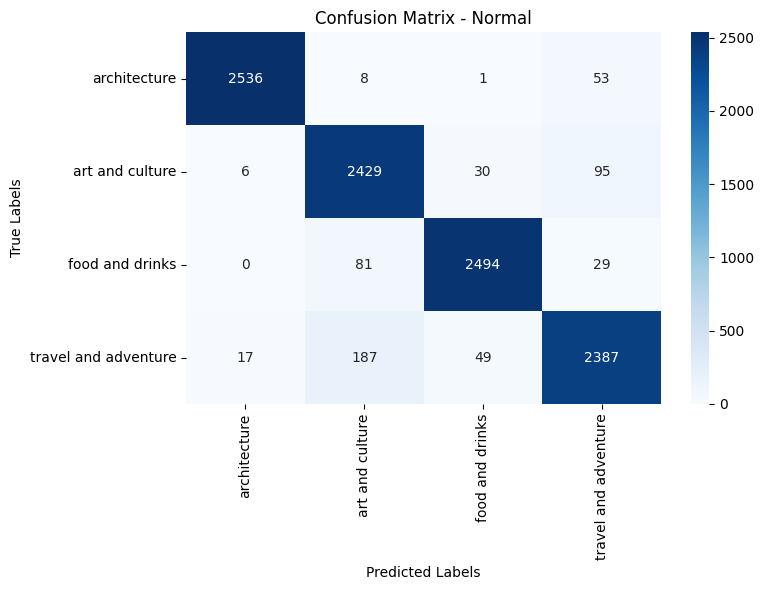

In [ ]:
plot_confusion_matrix_from_file("report/normal_preds.npz", class_names, "Normal")

## **9.2 Plot the confusion matrix for the Low Light dataset**

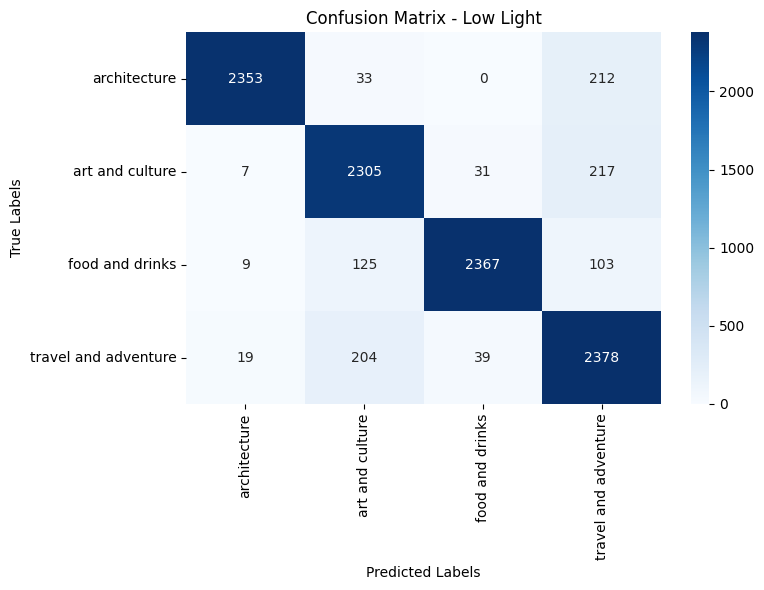

In [ ]:
plot_confusion_matrix_from_file("report/low_light_preds.npz", class_names, "Low Light")

## **9.3 Plot the confusion matrix for the Low Light + Noise dataset**

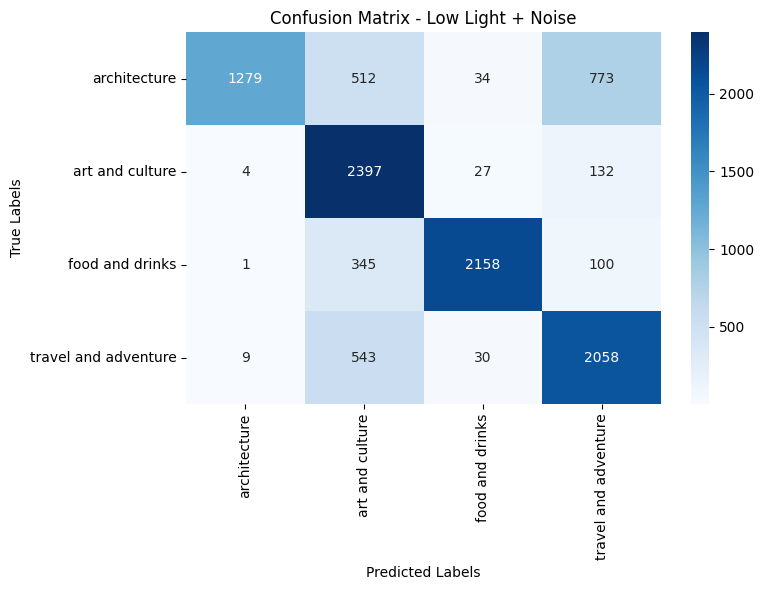

In [ ]:
plot_confusion_matrix_from_file("report/low_light_noise_preds.npz", class_names, "Low Light + Noise")

## **9.4 Plot the confusion matrix for the Enhanced HE Low Light dataset**

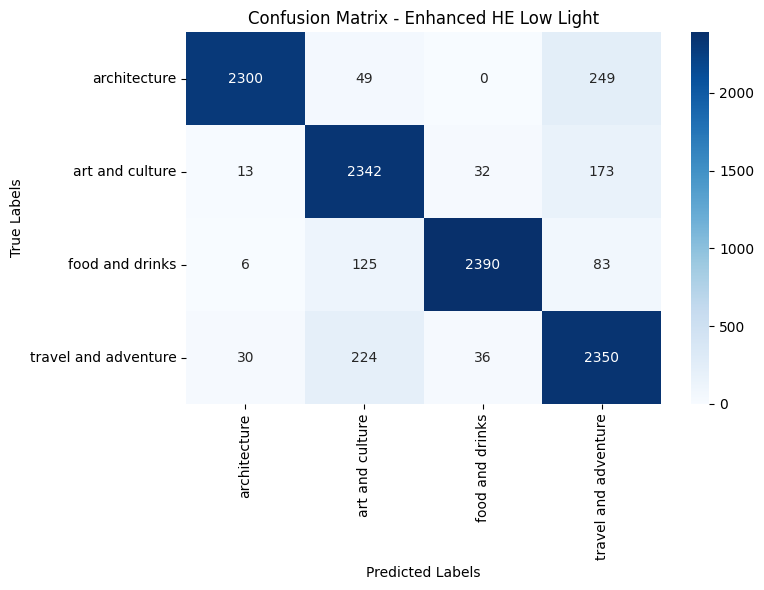

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_he_low_light_preds.npz", class_names, "Enhanced HE Low Light")

## **9.5 Plot the confusion matrix for the Enhanced HE Low Light + Noise dataset**

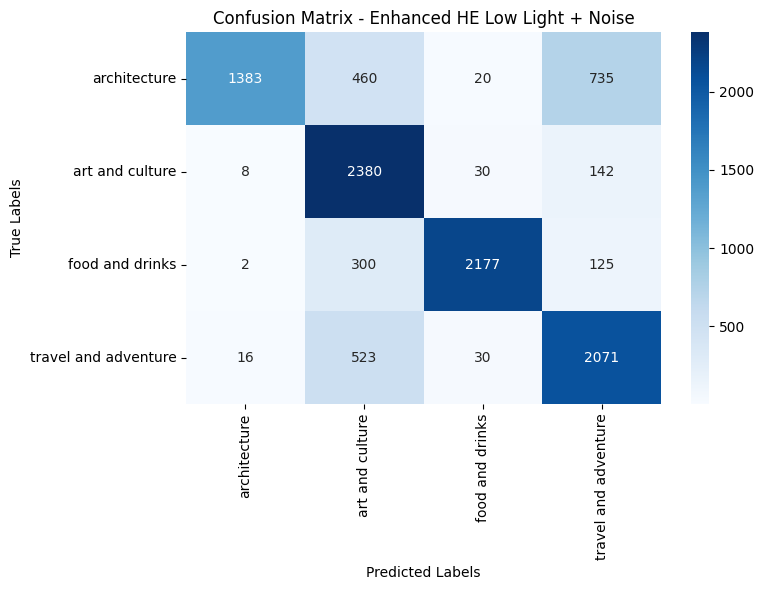

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_he_low_light_noise_preds.npz", class_names, "Enhanced HE Low Light + Noise")

## **9.6 Plot the confusion matrix for the Enhanced Retinex Low Light dataset**

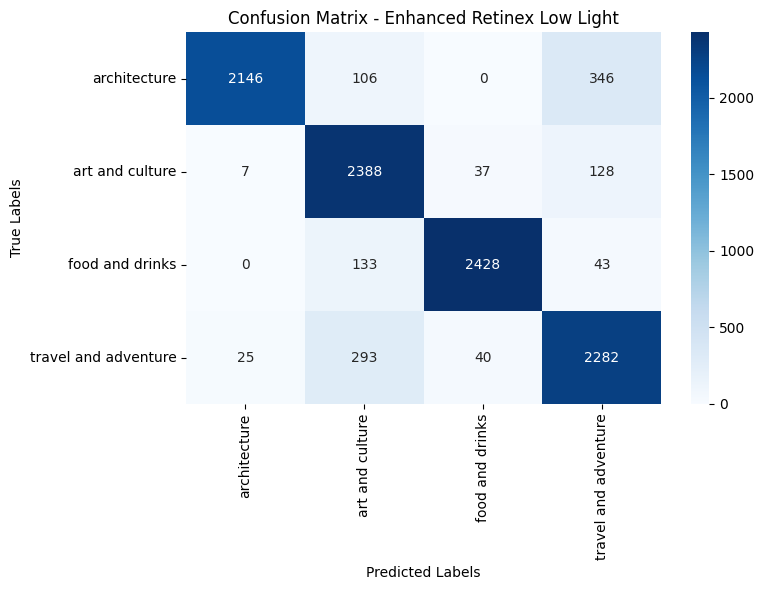

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_retinex_low_light_preds.npz", class_names, "Enhanced Retinex Low Light")

## **9.7 Plot the confusion matrix for the Enhanced Retinex Low Light + Noise dataset**

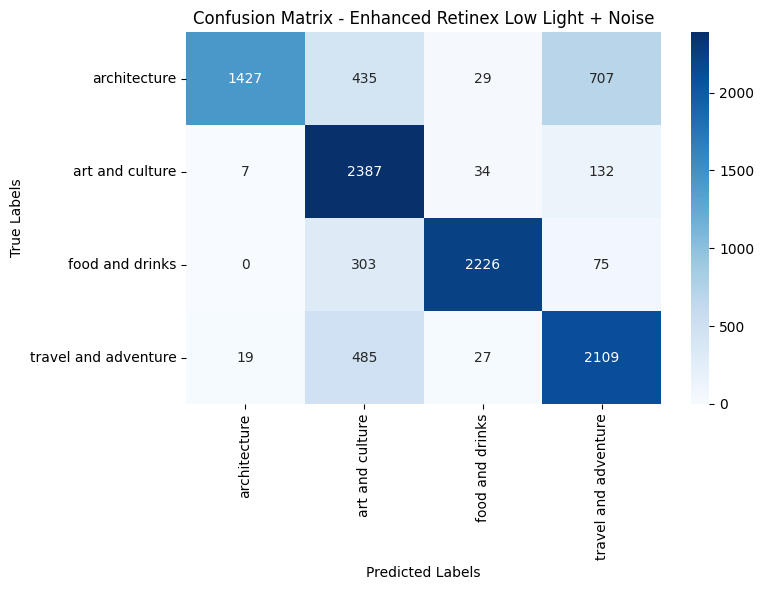

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_retinex_low_light_noise_preds.npz", class_names, "Enhanced Retinex Low Light + Noise")

## **9.8 Plot the confusion matrix for the Enhanced Wavelet Low Light dataset**

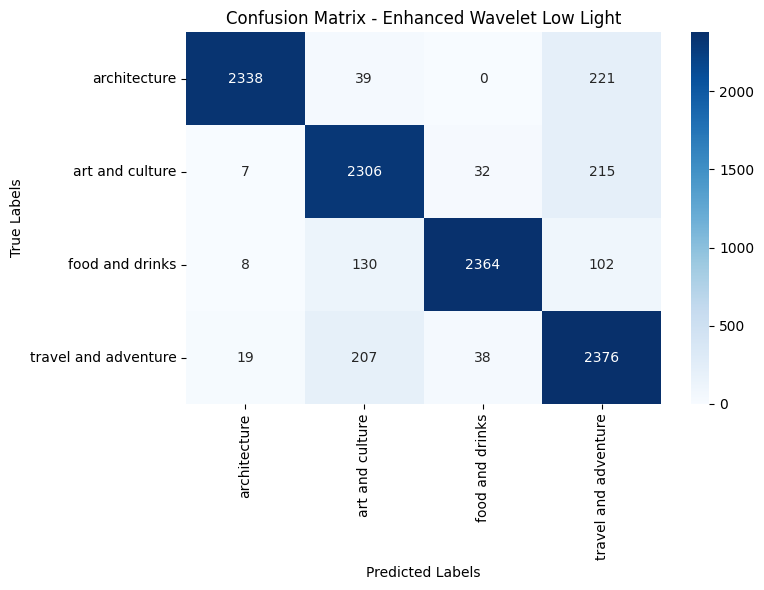

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_wavelet_low_light_preds.npz", class_names, "Enhanced Wavelet Low Light")

## **9.9 Plot the confusion matrix for the Enhanced Wavelet Low Light + Noise dataset**

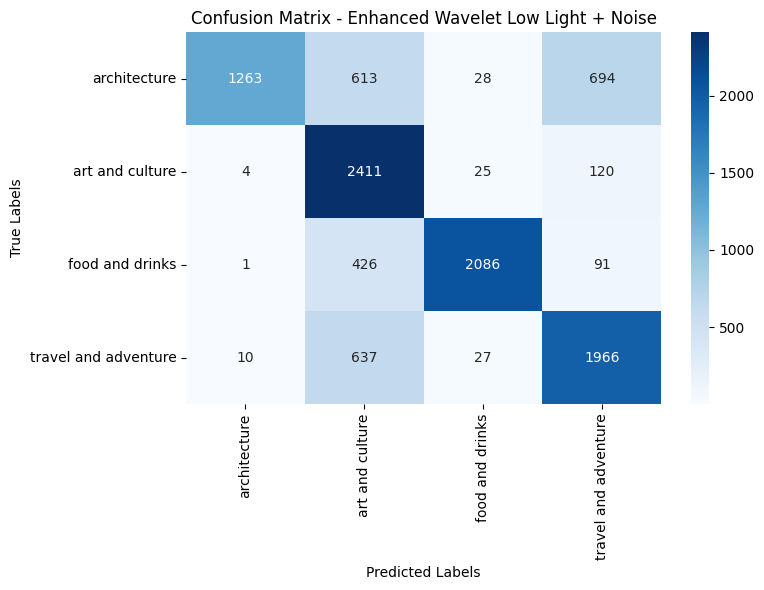

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_wavelet_low_light_noise_preds.npz", class_names, "Enhanced Wavelet Low Light + Noise")

## **9.10 Plot the confusion matrix for the Enhanced CNN Low Light dataset**

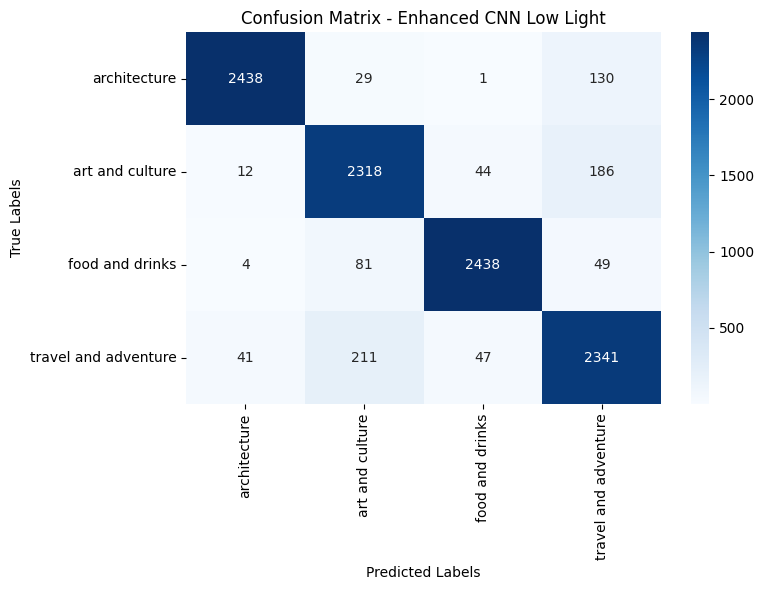

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_cnn_low_light_preds.npz", class_names, "Enhanced CNN Low Light")

## **9.11 Plot the confusion matrix for the Enhanced CNN Low Light + Noise dataset**

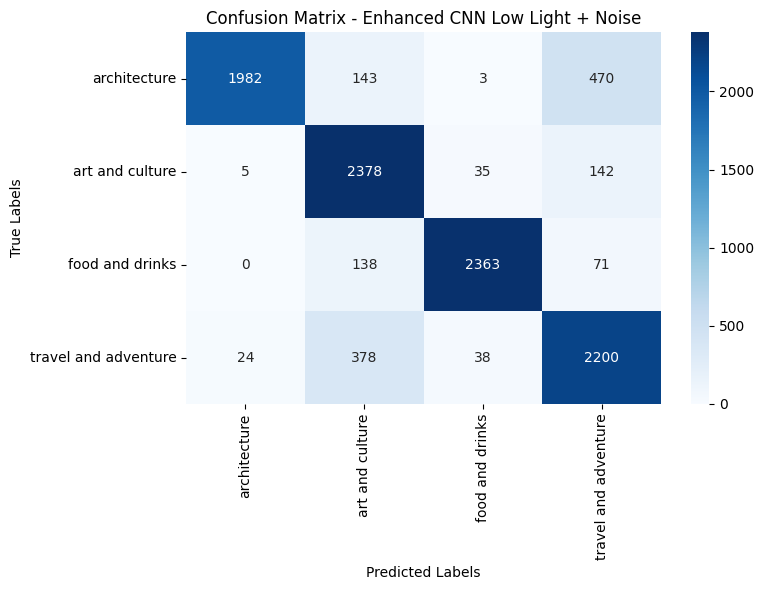

In [ ]:
plot_confusion_matrix_from_file("report/enhanced_cnn_low_light_noise_preds.npz", class_names, "Enhanced CNN Low Light + Noise")

## **9.12 Plot grouped confusion matrices for all datasets (clean and noise)**

In [ ]:
def plot_multiple_confusion_matrices(file_paths, titles, class_names, ncols=3, max_per_figure=6, suptitle_prefix=""):
    n = len(file_paths)
    num_figures = (n + max_per_figure - 1) // max_per_figure

    for fig_idx in range(num_figures):
        start_idx = fig_idx * max_per_figure
        end_idx = min(start_idx + max_per_figure, n)
        sub_file_paths = file_paths[start_idx:end_idx]
        sub_titles = titles[start_idx:end_idx]

        n_sub = len(sub_file_paths)
        nrows = (n_sub + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
        axes = axes.flatten()

        for i, (path, title) in enumerate(zip(sub_file_paths, sub_titles)):
            data = np.load(path)
            y_true = np.argmax(data["labels"], axis=1)
            y_pred = np.argmax(data["predictions"], axis=1)
            cm = confusion_matrix(y_true, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                        xticklabels=class_names,
                        yticklabels=class_names,
                        ax=axes[i])
            axes[i].set_title(title, fontsize=10)
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("True")

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f"{suptitle_prefix} Confusion Matrices {start_idx+1}–{end_idx}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def plot_grouped_confusion_matrices(folder_path, class_names, ncols=3, max_per_figure=6):
    # Tìm và chia nhóm file
    all_files = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".npz")
    ])

    noise_files = [f for f in all_files if "noise" in f.lower()]
    clean_files = [f for f in all_files if "noise" not in f.lower()]

    noise_titles = [os.path.splitext(os.path.basename(p))[0].replace("_", " ").title() for p in noise_files]
    clean_titles = [os.path.splitext(os.path.basename(p))[0].replace("_", " ").title() for p in clean_files]

    # Vẽ từng nhóm
    if clean_files:
        plot_multiple_confusion_matrices(clean_files, clean_titles, class_names, ncols, max_per_figure, suptitle_prefix="Clean")
    if noise_files:
        plot_multiple_confusion_matrices(noise_files, noise_titles, class_names, ncols, max_per_figure, suptitle_prefix="Noise")

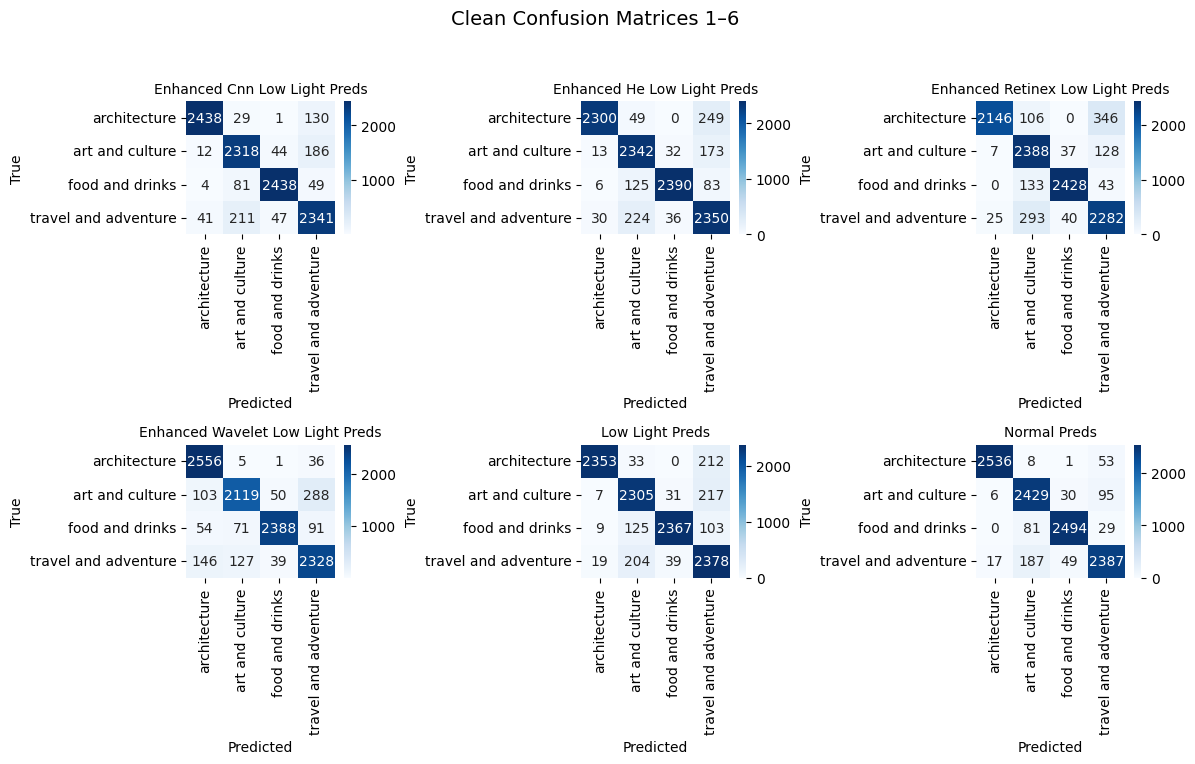

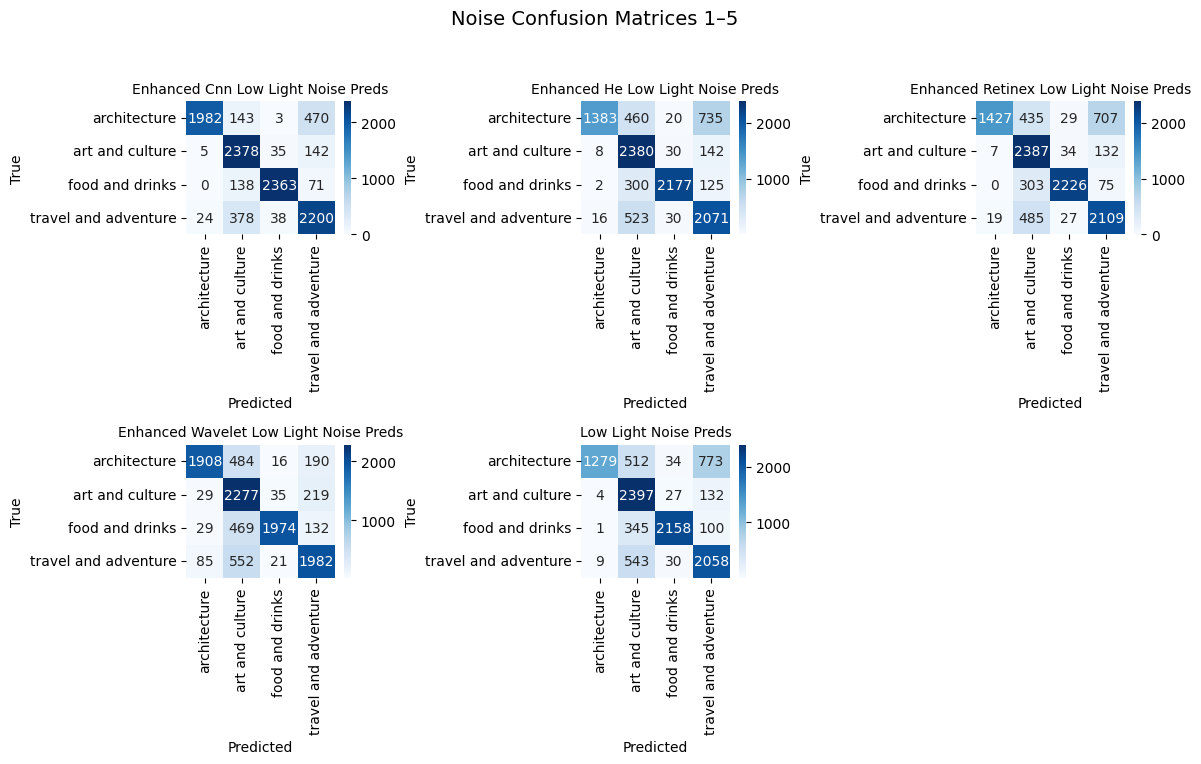

In [ ]:
plot_grouped_confusion_matrices("report", class_names, ncols=3, max_per_figure=6)

# **10. ROC Curve Comparison – Clean vs. Noisy Images**

In [ ]:
def plot_combined_roc_grouped(folder_path, class_names):
    # Tìm tất cả file .npz và chia nhóm
    all_files = sorted([
        f for f in os.listdir(folder_path)
        if f.endswith(".npz")
    ])
    noise_files = [f for f in all_files if "noise" in f.lower()]
    clean_files = [f for f in all_files if "noise" not in f.lower()]

    def plot_group(npz_files, group_name):
        plt.figure(figsize=(10, 8))
        for file_name in npz_files:
            npz_path = os.path.join(folder_path, file_name)
            method_name = os.path.splitext(file_name)[0].replace("_", " ").title()

            data = np.load(npz_path)
            y_true = np.argmax(data["labels"], axis=1)
            y_score = data["predictions"]
            n_classes = len(class_names)

            y_true_bin = label_binarize(y_true, classes=range(n_classes))
            fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, lw=2, label=f'{method_name} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve Comparison - {group_name}', fontsize=14)
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ✅ GỌI các nhóm ở ngoài hàm
    if clean_files:
        plot_group(clean_files, "Clean Data (Without Noise)")
    if noise_files:
        plot_group(noise_files, "Noisy Data (With Noise)")


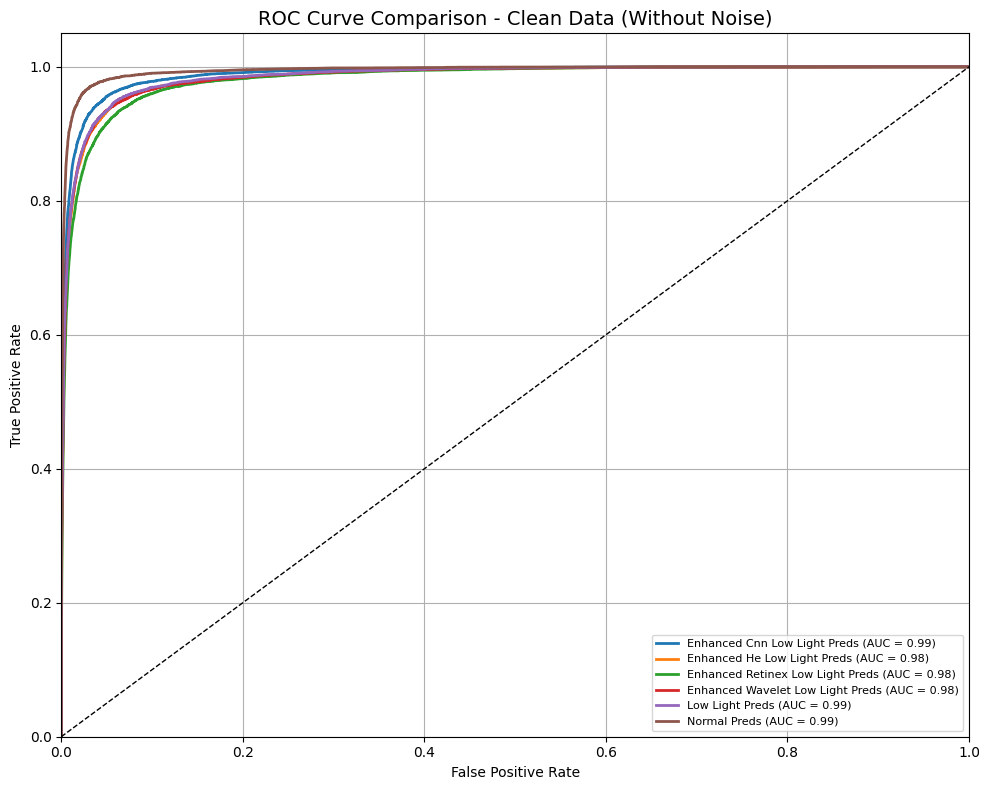

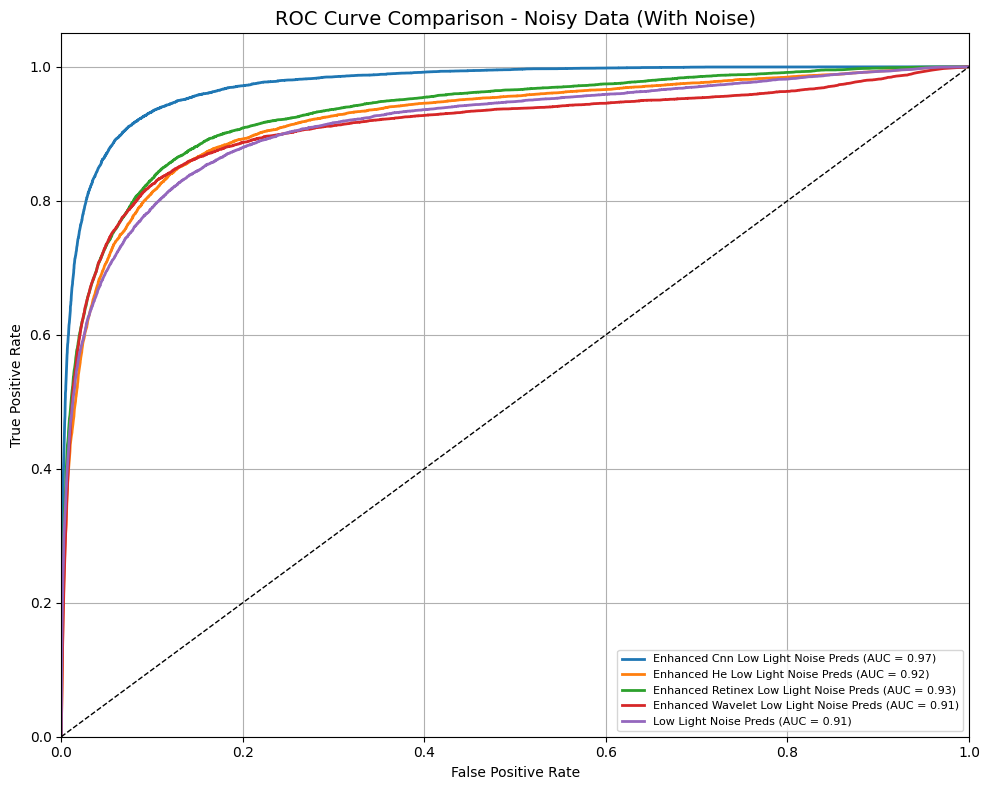

In [ ]:
plot_combined_roc_grouped("report", class_names)

# **11. Show image**

In [ ]:
def show_comparison_across_methods(filename=None, class_name=None, img_size=(224, 224)):
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')

    method_dirs = {
        "Original (Normal)": test_dir,
        "Low Light": low_light_dir,
        "Low Light + Noise": low_light_noise_dir,
        "HE": enhanced_he_low_light_dir,
        "HE + Noise": enhanced_he_low_light_noise_dir,
        "Retinex": enhanced_retinex_low_light_dir,
        "Retinex + Noise": enhanced_retinex_low_light_noise_dir,
        "Wavelet": enhanced_wavelet_low_light_dir,
        "Wavelet + Noise": enhanced_wavelet_low_light_noise_dir,
        "CNN": enhanced_cnn_low_light_dir,
        "CNN + Noise": enhanced_cnn_low_light_noise_dir
    }

    # Nếu không truyền class_name thì chọn class ngẫu nhiên
    if class_name is None:
        class_name = random.choice(os.listdir(test_dir))

    # Danh sách ảnh trong class
    class_path = os.path.join(test_dir, class_name)
    valid_files = [f for f in os.listdir(class_path) if f.lower().endswith(valid_exts)]

    if not valid_files:
        print(f"⚠️ Không có ảnh hợp lệ trong lớp: {class_name}")
        return

    # Nếu không truyền filename thì chọn ảnh ngẫu nhiên trong class đó
    if filename is None:
        filename = random.choice(valid_files)

    print(f"🖼️ Lớp: {class_name} | Ảnh: {filename}")

    # Tạo subplot
    n = len(method_dirs)
    n_cols = 4
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for idx, (label, folder) in enumerate(method_dirs.items()):
        img_path = os.path.join(folder, class_name, filename)
        if not os.path.exists(img_path):
            print(f"⚠️ Không tìm thấy: {img_path}")
            continue

        img = cv.imread(img_path)
        if img is None:
            print(f"⚠️ Không thể đọc ảnh: {img_path}")
            continue

        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, img_size)

        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

🖼️ Lớp: art and culture | Ảnh: 0_02068.jpg


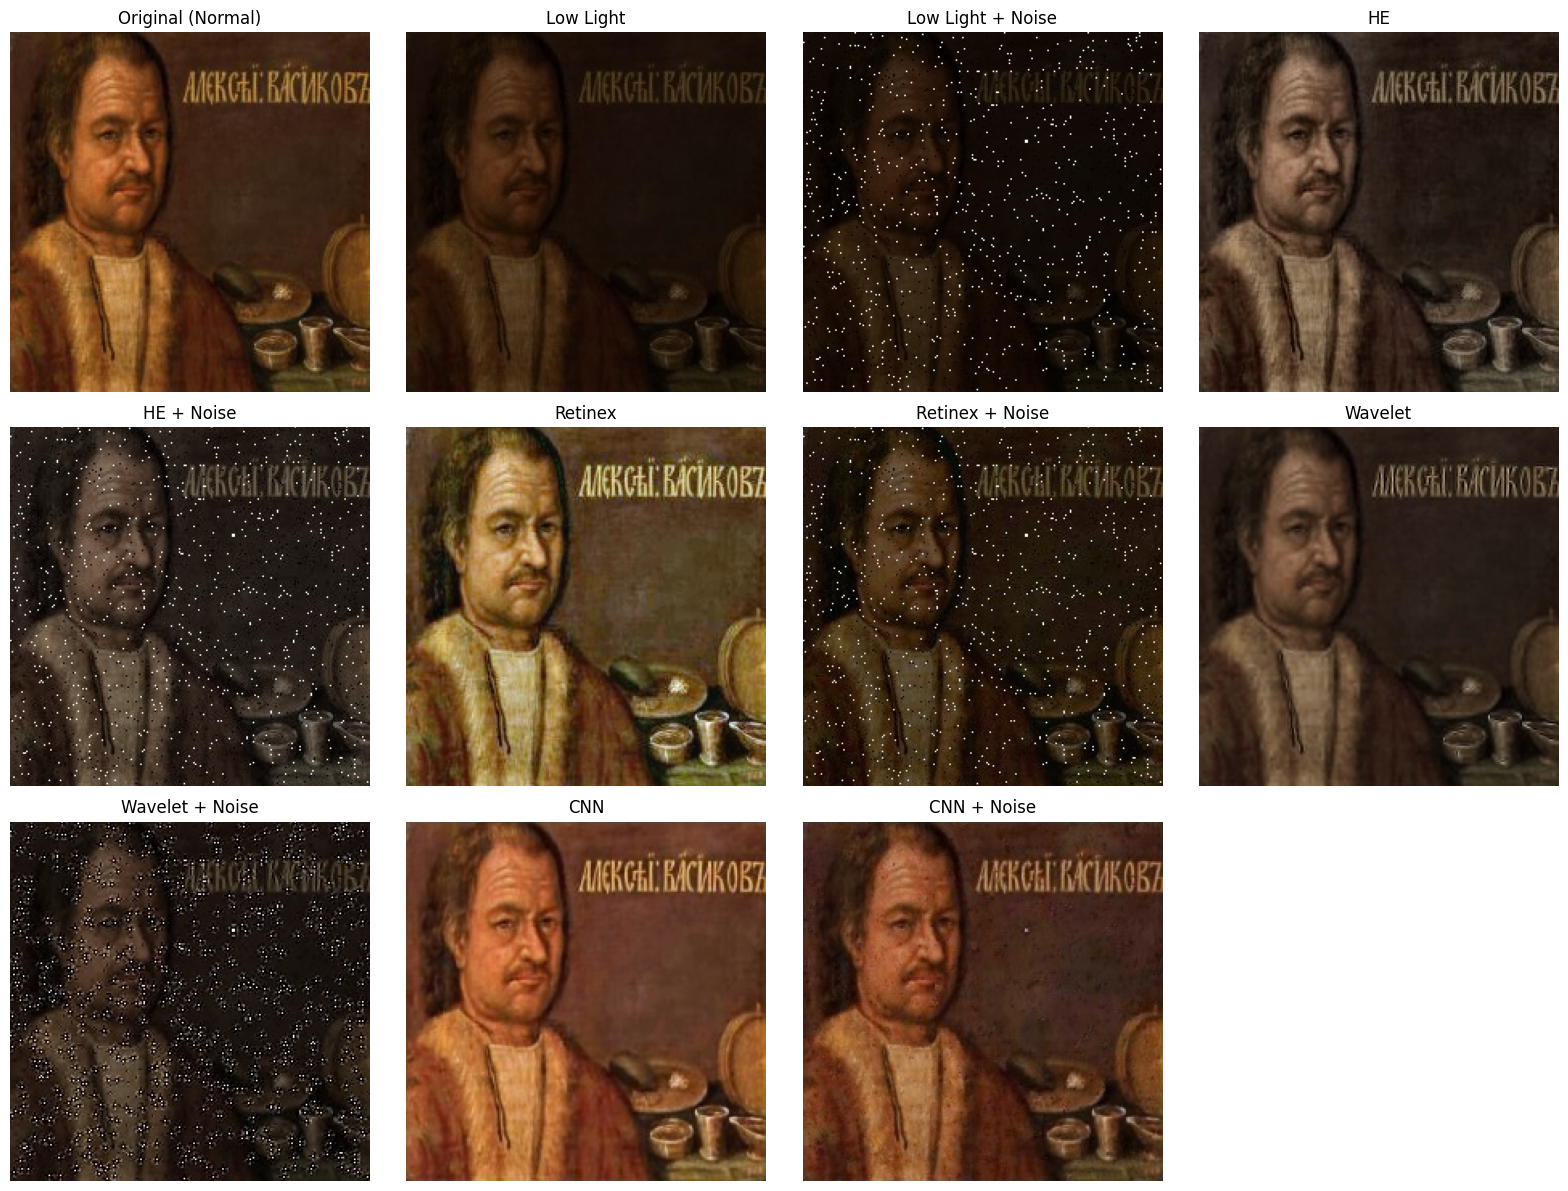

In [ ]:
show_comparison_across_methods()

# **12. PSNR vs. SSIM**

In [ ]:
def get_all_images(root_dir, valid_exts):
    files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for f in filenames:
            if f.lower().endswith(valid_exts):
                # Lấy đường dẫn ảnh theo đường dẫn đầy đủ hoặc đường dẫn tương đối
                full_path = os.path.join(dirpath, f)
                rel_path = os.path.relpath(full_path, root_dir)  # để so khớp tên ảnh có cả thư mục con
                files.append(rel_path)
    return files

def calculate_and_save_metrics_per_image(method_name, method_dir, reference_dir, img_size=(224,224), save_csv=True):
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
    # Đảm bảo thư mục 'metrics' tồn tại
    metrics_dir = "metrics"
    os.makedirs(metrics_dir, exist_ok=True)

    csv_file = os.path.join(metrics_dir, f"metrics_{method_name.replace(' ', '_').lower()}.csv")

    if os.path.exists(csv_file):
        df_existing = pd.read_csv(csv_file)
    else:
        df_existing = pd.DataFrame(columns=["Filename", "PSNR", "SSIM"])

    processed_files = set(df_existing["Filename"].tolist())

    all_files = get_all_images(method_dir, valid_exts)

    for filename in tqdm(all_files, desc=f"Processing {method_name}"):
        if filename in processed_files:
            continue

        original_path = os.path.join(reference_dir, filename)
        compare_path = os.path.join(method_dir, filename)

        if not os.path.exists(original_path) or not os.path.exists(compare_path):
            tqdm.write(f"⚠️ Missing file for {filename}, skipped.")
            continue

        original_img = cv.imread(original_path)
        compare_img = cv.imread(compare_path)

        if original_img is None or compare_img is None:
            tqdm.write(f"⚠️ Cannot read image {filename}, skipped.")
            continue

        original_img = cv.cvtColor(original_img, cv.COLOR_BGR2RGB)
        compare_img = cv.cvtColor(compare_img, cv.COLOR_BGR2RGB)

        original_img = cv.resize(original_img, img_size)
        compare_img = cv.resize(compare_img, img_size)

        try:
            mse = np.mean((original_img - compare_img) ** 2)
            psnr_val = float('inf') if mse == 0 else 10 * np.log10((255 ** 2) / mse)
            ssim_val = ssim(original_img, compare_img, data_range=255, channel_axis=-1)

            new_row = pd.DataFrame({"Filename": [filename], "PSNR": [psnr_val], "SSIM": [ssim_val]})
            df_existing = pd.concat([df_existing, new_row], ignore_index=True)
            processed_files.add(filename)
        except Exception as e:
            tqdm.write(f"⚠️ Error for {filename}: {e}")

        if len(df_existing) % 100 == 0 and save_csv:
            df_existing.to_csv(csv_file, index=False)

    if save_csv:
        df_existing.to_csv(csv_file, index=False)
        print(f"📄 Saved metrics to {csv_file}")

    return df_existing

In [ ]:
# Tính metrics và lưu csv
df_low_light = calculate_and_save_metrics_per_image("Low Light", low_light_dir, test_dir)

Processing Low Light: 100%|██████████| 10402/10402 [3:38:24<00:00,  1.26s/it]

📄 Saved metrics to metrics/metrics_low_light.csv


In [ ]:
df_low_light_noise = calculate_and_save_metrics_per_image("Low Light Noise", low_light_noise_dir, test_dir)

Processing Low Light Noise: 100%|██████████| 10402/10402 [1:57:08<00:00,  1.48it/s]

📄 Saved metrics to metrics/metrics_low_light_noise.csv


In [ ]:
df_enhanced_he_low_light = calculate_and_save_metrics_per_image("Enhanced HE Low Light", enhanced_he_low_light_dir, test_dir)

Processing Enhanced HE Low Light: 100%|██████████| 10402/10402 [1:38:57<00:00,  1.75it/s]

📄 Saved metrics to metrics/metrics_enhanced_he_low_light.csv


In [ ]:
df_enhanced_he_low_light_noise = calculate_and_save_metrics_per_image("Enhanced HE Low Light Noise", enhanced_he_low_light_noise_dir, test_dir)

Processing Enhanced HE Low Light Noise: 100%|██████████| 10402/10402 [39:52<00:00,  4.35it/s]

📄 Saved metrics to metrics/metrics_enhanced_he_low_light_noise.csv


In [ ]:
df_enhanced_retinex_low_light = calculate_and_save_metrics_per_image("Enhanced Retinex Low Light", enhanced_retinex_low_light_dir, test_dir)

Processing Enhanced Retinex Low Light: 100%|██████████| 10402/10402 [41:05<00:00,  4.22it/s]

📄 Saved metrics to metrics/metrics_enhanced_retinex_low_light.csv


In [ ]:
df_enhanced_retinex_low_light_noise = calculate_and_save_metrics_per_image("Enhanced Retinex Low Light Noise", enhanced_retinex_low_light_noise_dir, test_dir)

Processing Enhanced Retinex Low Light Noise: 100%|██████████| 10402/10402 [36:59<00:00,  4.69it/s]

📄 Saved metrics to metrics/metrics_enhanced_retinex_low_light_noise.csv


In [ ]:
df_enhanced_wavelet_low_light = calculate_and_save_metrics_per_image("Enhanced Wavelet Low Light", enhanced_wavelet_low_light_dir, test_dir)

Processing Enhanced Wavelet Low Light: 100%|██████████| 10402/10402 [36:34<00:00,  4.74it/s]

📄 Saved metrics to metrics/metrics_enhanced_wavelet_low_light.csv


In [ ]:
df_enhanced_wavelet_low_light_noise = calculate_and_save_metrics_per_image("Enhanced Wavelet Low Light Noise", enhanced_wavelet_low_light_noise_dir, test_dir)

Processing Enhanced Wavelet Low Light Noise: 100%|██████████| 10402/10402 [38:01<00:00,  4.56it/s]


📄 Saved metrics to metrics/metrics_enhanced_wavelet_low_light_noise.csv


In [ ]:
df_enhanced_cnn_low_light = calculate_and_save_metrics_per_image("Enhanced CNN Low Light", enhanced_cnn_low_light_dir, test_dir)

Processing Enhanced CNN Low Light: 100%|██████████| 10370/10370 [37:45<00:00,  4.58it/s]

📄 Saved metrics to metrics/metrics_enhanced_cnn_low_light.csv


In [ ]:
df_enhanced_cnn_low_light_noise = calculate_and_save_metrics_per_image("Enhanced CNN Low Light Noise", enhanced_cnn_low_light_noise_dir, test_dir)

Processing Enhanced CNN Low Light Noise: 100%|██████████| 10370/10370 [39:30<00:00,  4.37it/s]

📄 Saved metrics to metrics/metrics_enhanced_cnn_low_light_noise.csv


In [ ]:
def load_all_metrics_summary(metrics_dir="metrics"):
    summary_list = []

    # Duyệt qua tất cả các file .csv trong thư mục
    for filename in os.listdir(metrics_dir):
        if filename.endswith(".csv"):
            method_name = filename.replace("metrics_", "").replace(".csv", "").replace("_", " ").title()
            csv_path = os.path.join(metrics_dir, filename)

            try:
                df = pd.read_csv(csv_path)
                num_images = len(df)
                mean_psnr = df["PSNR"].mean() if num_images > 0 else float('nan')
                mean_ssim = df["SSIM"].mean() if num_images > 0 else float('nan')

                summary_list.append({
                    "Method": method_name,
                    "Num_Images": num_images,
                    "Mean_PSNR": mean_psnr,
                    "Mean_SSIM": mean_ssim
                })

            except Exception as e:
                print(f"⚠️ Lỗi khi đọc {filename}: {e}")

    # Tạo bảng tổng hợp
    summary_df = pd.DataFrame(summary_list)
    summary_df = summary_df.sort_values(by="Mean_PSNR", ascending=False).reset_index(drop=True)
    return summary_df

In [ ]:
summary_table = load_all_metrics_summary("metrics")
print(summary_table)

                             Method  Num_Images  Mean_PSNR  Mean_SSIM
0      Enhanced Cnn Low Light Noise       10370  28.831553   0.808646
1            Enhanced Cnn Low Light       10370  28.662047   0.805823
2        Enhanced Retinex Low Light       10402  28.513258   0.841522
3  Enhanced Retinex Low Light Noise       10402  28.368001   0.655734
4       Enhanced He Low Light Noise       10402  28.348527   0.634311
5             Enhanced He Low Light       10402  28.304556   0.699327
6        Enhanced Wavelet Low Light       10402  28.144342   0.624499
7  Enhanced Wavelet Low Light Noise       10402  28.140806   0.599254
8                   Low Light Noise       10402  28.040811   0.390013
9                         Low Light       10402  28.019848   0.385817
